In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2022-10-16 15:09:01--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1,4M) [text/plain]
Saving to: ‘housing.csv’

housing.csv         100%[===================>]   1,36M  1,01MB/s    in 1,3s    

2022-10-16 15:09:03 (1,01 MB/s) - ‘housing.csv’ saved [1423529/1423529]



In [47]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (mutual_info_score, 
                             accuracy_score,
                             mean_squared_error, 
                             roc_auc_score, 
                             auc)
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer

from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [16]:
SEED = 1

In [4]:
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [11]:
target = 'median_house_value'

features = df.columns[df.columns != target].to_list()
features

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'ocean_proximity']

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [10]:
df.fillna(0, inplace=True)

In [12]:
df[target] = np.log1p(df[target].values)

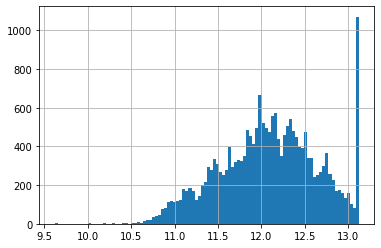

In [14]:
df[target].hist(bins=100);

In [17]:
df_train_val, df_test = train_test_split(df, test_size=.2, random_state=SEED)
df_train_val.shape, df_test.shape

((16512, 10), (4128, 10))

In [18]:
df_train, df_val = train_test_split(
    df_train_val, 
    test_size=df_test.shape[0] / df_train_val.shape[0], 
    random_state=SEED
)
df_train.shape, df_val.shape

((12384, 10), (4128, 10))

In [22]:
y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

In [23]:
del df_train[target]
del df_val[target]
del df_test[target]

In [19]:
dv = DictVectorizer(sparse=False)
train_dict = df_train[features].to_dict(orient='records')
dv.fit(train_dict)
X_train = dv.transform(train_dict)

In [38]:
val_dict = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [39]:
test_dict = df_test[features].to_dict(orient='records')
X_test = dv.transform(test_dict)

In [21]:
dt = DecisionTreeRegressor(max_depth=1)

In [25]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [33]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



# Q1
Which feature is used for splitting the data?  
**ocean_proximity=INLAND**

In [36]:
rf = RandomForestRegressor(
    n_estimators=10,
    random_state=SEED,
    n_jobs=-1
)

In [37]:
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [41]:
y_pred = rf.predict(X_val)

In [42]:
mean_squared_error(y_val, y_pred, squared=False)

0.2456601287532493

# Q2
What's the RMSE of this model on validation?  
**0.25**

In [50]:
rf_n_est_rmse = []
for n_est in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(
        n_estimators=n_est,
        random_state=SEED,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rf_n_est_rmse.append((n_est, mean_squared_error(y_val, y_pred, squared=False)))
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.47s/it]


In [66]:
res = pd.DataFrame(rf_n_est_rmse).set_index(0)
res[res[1] == res[1].min()]

,1
0,
170,0.231432


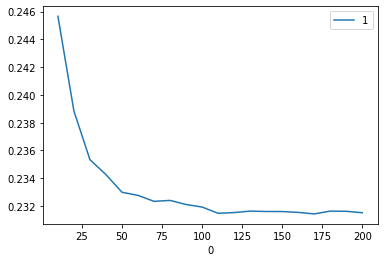

In [68]:
res.plot();

# Q3 
After which value of n_estimators does RMSE stop improving?  
10, 50, 70, 150  
**150**

In [69]:
rf_n_est_rmse = []
for max_depth in [10, 15, 20, 25]:
    for n_est in tqdm(range(10, 201, 10)):
        rf = RandomForestRegressor(
            n_estimators=n_est,
            max_depth=max_depth,
            random_state=SEED,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rf_n_est_rmse.append((n_est, max_depth, mean_squared_error(y_val, y_pred, squared=False)))

res = pd.DataFrame(rf_n_est_rmse, columns=['n_est', 'max_depth', 'rmse'])
res[res['rmse'] == res['rmse'].min()]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.58s/it]


,n_est,max_depth,rmse
71,120,25,0.231334


# Q4
What's the best max_depth?  
**25**

In [71]:
rf = RandomForestRegressor(
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [77]:
df_q5 = pd.DataFrame((dv.get_feature_names(), rf.feature_importances_)).T
df_q5.columns = ['feature', 'importance']
df_q5

/home/ska/miniconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature,importance
0,households,0.016387
1,housing_median_age,0.033145
2,latitude,0.101256
3,longitude,0.09647
4,median_income,0.363326
5,ocean_proximity=<1H OCEAN,0.002489
6,ocean_proximity=INLAND,0.310901
7,ocean_proximity=ISLAND,0.000357
8,ocean_proximity=NEAR BAY,0.00048
9,ocean_proximity=NEAR OCEAN,0.004699


In [79]:
df_q5.sort_values('importance', ascending=False)

,feature,importance
4,median_income,0.363326
6,ocean_proximity=INLAND,0.310901
2,latitude,0.101256
3,longitude,0.09647
1,housing_median_age,0.033145
10,population,0.030777
12,total_rooms,0.020541
11,total_bedrooms,0.019172
0,households,0.016387
9,ocean_proximity=NEAR OCEAN,0.004699


# Q5
What's the most important feature?  
**median_income**

In [80]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.9/255.9 MB 3.0 MB/s eta 0:00:00m eta 0:00:010:00:02


In [81]:
import xgboost as xgb

In [83]:
dv.get_feature_names()

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1H OCEAN',
 'ocean_proximity=INLAND',
 'ocean_proximity=ISLAND',
 'ocean_proximity=NEAR BAY',
 'ocean_proximity=NEAR OCEAN',
 'population',
 'total_bedrooms',
 'total_rooms']

In [88]:
dm_train = xgb.DMatrix(X_train, label=y_train)
dm_val = xgb.DMatrix(X_val, label=y_val)

In [90]:
evals = [(dm_train, 'train'), (dm_val, 'val')]

In [96]:
for eta in [0.1, 0.3, 0.5]:
    xgb_params = {
        'eta': eta, 
        'max_depth': 6,
        'min_child_weight': 1,

        'objective': 'reg:squarederror',
        'nthread': 8,

        'seed': 1,
        'verbosity': 1,
    }
    model = xgb.train(
        xgb_params, 
        dm_train, 
        evals=evals,
        num_boost_round=200, 
        verbose_eval=0)
    y_pred = model.predict(dm_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    print(eta, rmse)

0.1 0.2242767450311036
0.3 0.22479291696836884
0.5 0.23807432809554155


# Q6
Which eta leads to the best RMSE score on the validation dataset?  
**0.1**